In [62]:
import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

import cv2


In [2]:
import warnings
warnings.filterwarnings("ignore")


In [3]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [5]:
df = pd.read_csv('/Users/ujash/Documents/StockPredictionJPM/JPM.csv',header=0, parse_dates=[0], date_parser=parser)
df = df[['Date', 'Close']]

In [6]:
df

,Date,Close
0,1980-03-17,5.037037
1,1980-03-18,5.074074
2,1980-03-19,5.148148
3,1980-03-20,5.111111
4,1980-03-21,5.222222
5,1980-03-24,5.092593
6,1980-03-25,5.074074
7,1980-03-26,5.111111
8,1980-03-27,5.074074
9,1980-03-28,5.018518


In [7]:
print('There are {} number of days in the dataset.'.format(df.shape[0]))

There are 9791 number of days in the dataset.


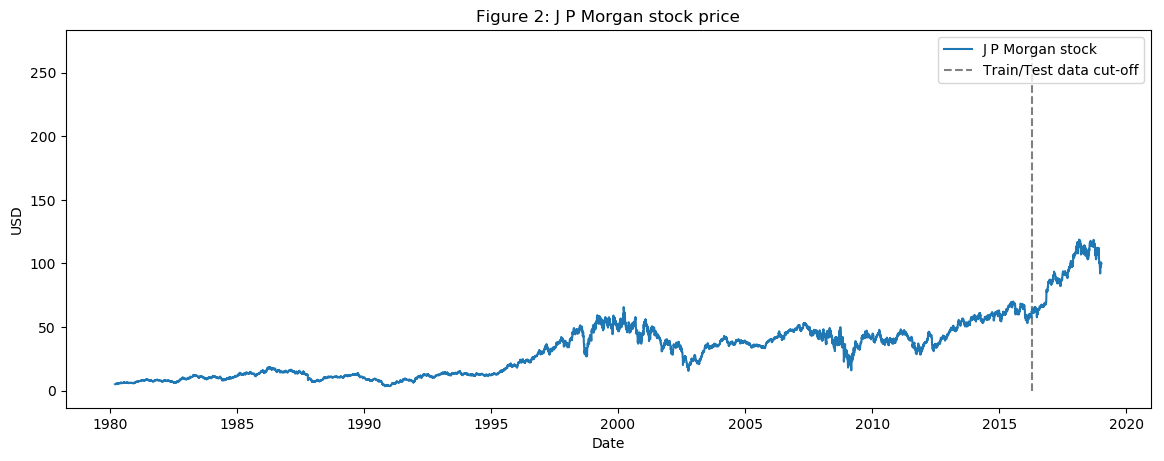

In [8]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df['Date'], df['Close'], label='J P Morgan stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: J P Morgan stock price')
plt.legend()
plt.show()

In [9]:

num_training_days = int(df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    df.shape[0]-num_training_days))



Number of training days: 6853. Number of test days: 2938.


In [10]:
def get_technical_indicators(df):
    # Create 7 and 21 days Moving Average
    df['ma7'] = df['Close'].rolling(window=7).mean()
    df['ma21'] = df['Close'].rolling(window=21).mean()
    
    # Create MACD
    close_26_ewma = df['Close'].ewm(span=26, min_periods=0, adjust=True, ignore_na=True).mean()
    close_12_ewma = df['Close'].ewm(span=12, min_periods=0, adjust=True, ignore_na=True).mean()
    df['26ema'] = close_26_ewma
    df['12ema'] = close_12_ewma
    df['MACD'] = (df['12ema'] - df['26ema'])
    df['MACD']
    
     # Create Bollinger Bands
    df['20sd'] = df['Close'].rolling(window=20).std()
    df['upper_band'] = df['ma21'] + (df['20sd']*2)
    df['lower_band'] = df['ma21'] - (df['20sd']*2)
    
    # Create Exponential moving average
    df['ema'] = df['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    df['momentum'] = df['Close']-1
    
    return df

In [11]:
dataset_TI_df = get_technical_indicators(df)
dataset_TI_df

,Date,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,1980-03-17,5.037037,NaN,NaN,5.037037,5.037037,0.000000,NaN,NaN,NaN,5.037037,4.037037
1,1980-03-18,5.074074,NaN,NaN,5.056268,5.057099,0.000831,NaN,NaN,NaN,5.064815,4.074074
2,1980-03-19,5.148148,NaN,NaN,5.089279,5.092635,0.003356,NaN,NaN,NaN,5.122507,4.148148
3,1980-03-20,5.111111,NaN,NaN,5.095383,5.098467,0.003085,NaN,NaN,NaN,5.114815,4.111111
4,1980-03-21,5.222222,NaN,NaN,5.124797,5.132091,0.007294,NaN,NaN,NaN,5.186715,4.222222
5,1980-03-24,5.092593,NaN,NaN,5.118347,5.122491,0.004144,NaN,NaN,NaN,5.123881,4.092593
6,1980-03-25,5.074074,5.108466,NaN,5.110473,5.111687,0.001214,NaN,NaN,NaN,5.090661,4.074074
7,1980-03-26,5.111111,5.119048,NaN,5.110576,5.111567,0.000991,NaN,NaN,NaN,5.104296,4.111111
8,1980-03-27,5.074074,5.119048,NaN,5.105166,5.104149,-0.001016,NaN,NaN,NaN,5.084147,4.074074
9,1980-03-28,5.018518,5.100529,NaN,5.093209,5.087922,-0.005287,NaN,NaN,NaN,5.040394,4.018518


In [12]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for J P Morgan - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()


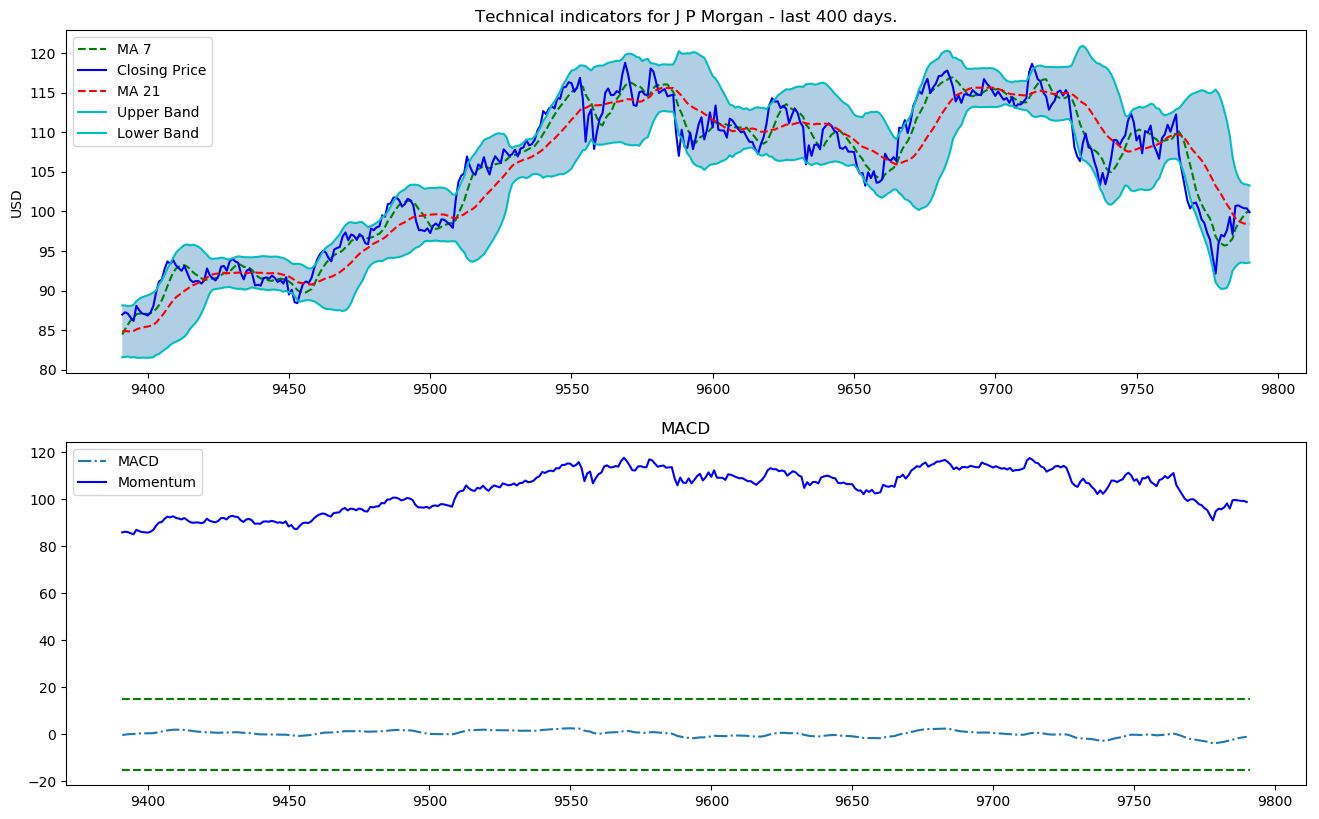

In [13]:
plot_technical_indicators(dataset_TI_df, 400)

In [14]:
import bert

In [15]:
data_FT = df[['Date', 'Close']]

In [16]:
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

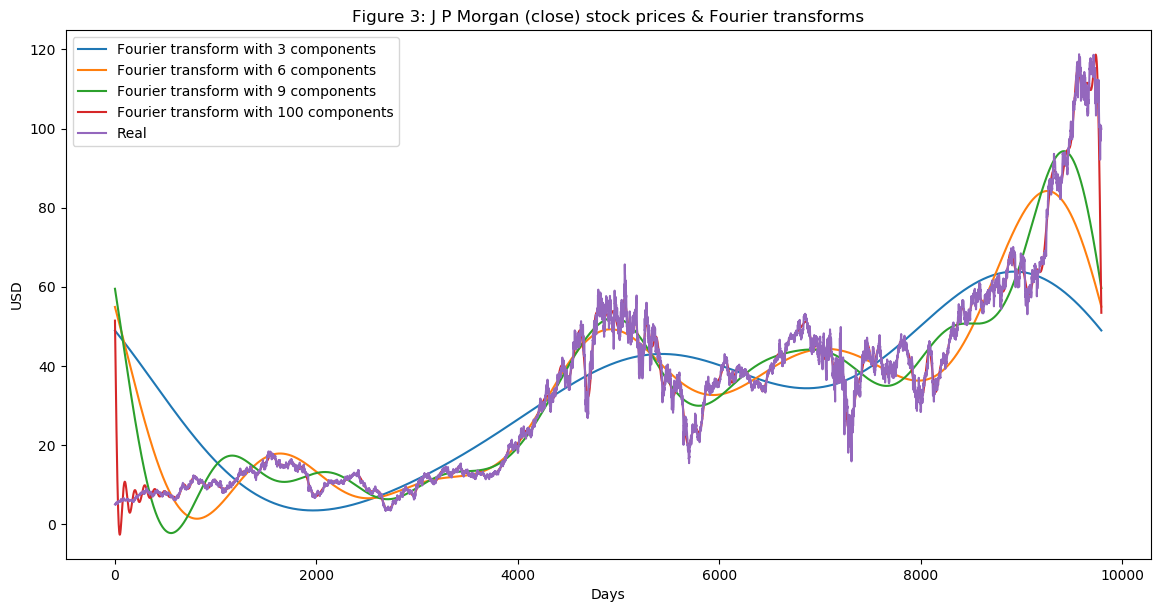

In [17]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: J P Morgan (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

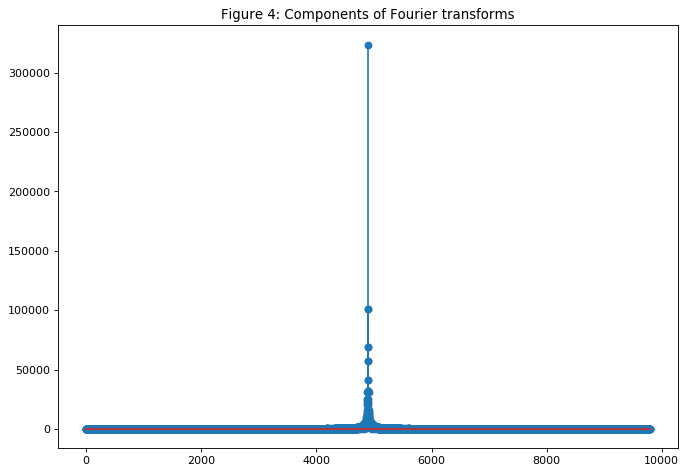

In [18]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [19]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 9790
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -11406.437
Method:                       css-mle   S.D. of innovations              0.776
Date:                Mon, 18 Mar 2019   AIC                          22826.875
Time:                        23:20:53   BIC                          22877.199
Sample:                             1   HQIC                         22843.927
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0097      0.007      1.398      0.162      -0.004       0.023
ar.L1.D.Close    -0.0482      0.010     -4.769      0.000      -0.068      -0.028
ar.L2.D.Close    -0.0333      0.010     

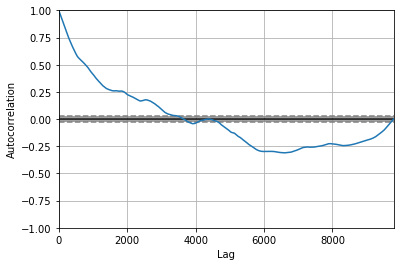

<Figure size 800x560 with 0 Axes>

In [20]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [21]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [22]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 1.087


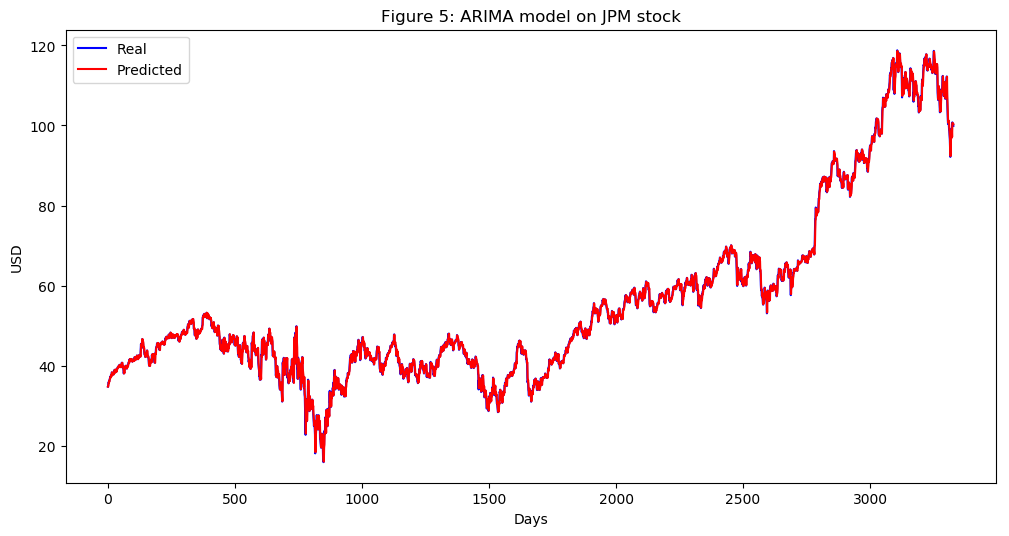

In [23]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real',color = 'blue')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on JPM stock')
plt.legend()
plt.show()

In [31]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 9791 samples, and 12 features.


In [24]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [25]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)

In [26]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [27]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [28]:
eval_result = regressor.evals_result()

In [29]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

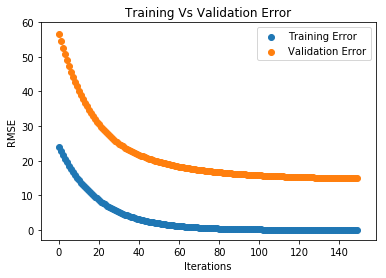

In [30]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

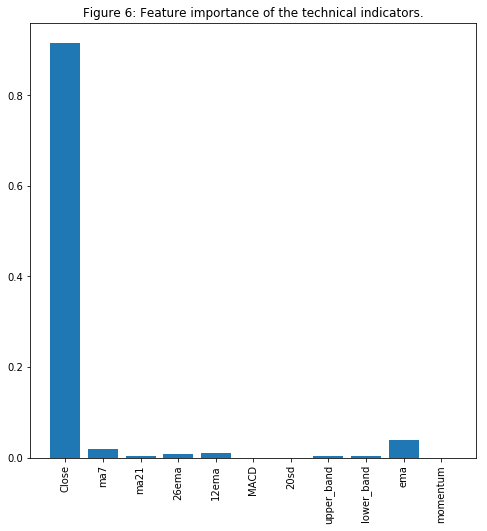

In [31]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

In [32]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

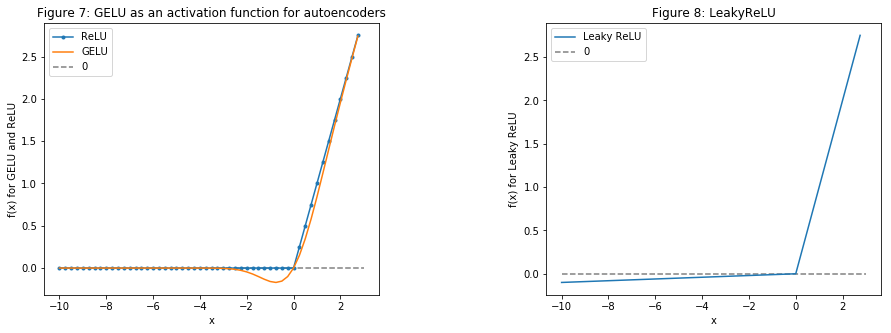

In [33]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()

plt.show()


In [34]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

import collections, numpy


Using TensorFlow backend.


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.examples.tutorials.mnist import input_data


mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
mb_size = 64
z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128
c = 0
lr = 1e-3


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


# =============================== Q(z|X) ======================================

X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X):
    h = tf.nn.relu(tf.matmul(X, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


# =============================== P(X|z) ======================================

P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z):
    h = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits


# =============================== TRAINING ====================================

z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample)

# Sampling from random z
X_samples, _ = P(z)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer().minimize(vae_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(1000000):
    X_mb, _ = mnist.train.next_batch(mb_size)

    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()

        samples = sess.run(X_samples, feed_dict={z: np.random.randn(16, z_dim)})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as offi

NameError: name 'X_train' is not defined